# **Importing All libraries and Packages needed**

In [2]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Loading Big Data**

In [42]:
csv_file = "train.csv"
data = pd.read_csv(csv_file, encoding='latin-1')

In [43]:
print(data.head())

   Sentiment          ID                                              Tweet
0          0  1467810672  is upset that he can't update his Facebook by ...
1          0  1467810917  @Kenichan I dived many times for the ball. Man...
2          0  1467811184    my whole body feels itchy and like its on fire 
3          0  1467811193  @nationwideclass no, it's not behaving at all....
4          0  1467811372                      @Kwesidei not the whole crew 


# **Data Cleaning & PreProcessing**

In [47]:
y = data['Sentiment']
y[y == 4] = 1

<ipython-input-47-0e894ba55ee3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 4] = 1


In [44]:
def preprocess_tweet(tweet):
    # Remove hashtags and special characters
    tweet = re.sub(r'#\w+|\W', ' ', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Tokenize the tweet
    tokens = word_tokenize(tweet)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    # Join the tokens together
    preprocessed_tweet = ' '.join(lemmatized_tokens)
    return preprocessed_tweet

In [7]:
# Apply preprocessing to the SentimentText column
data['ProcessedText'] = data['Tweet'].apply(preprocess_tweet)
print(data['ProcessedText'].head())

0    upset updat facebook text might cri result sch...
1    kenichan dive mani time ball manag save 50 res...
2                      whole bodi feel itchi like fire
3                        nationwideclass behav mad see
4                                  kwesidei whole crew
Name: ProcessedText, dtype: object


# **Data Visualisation**

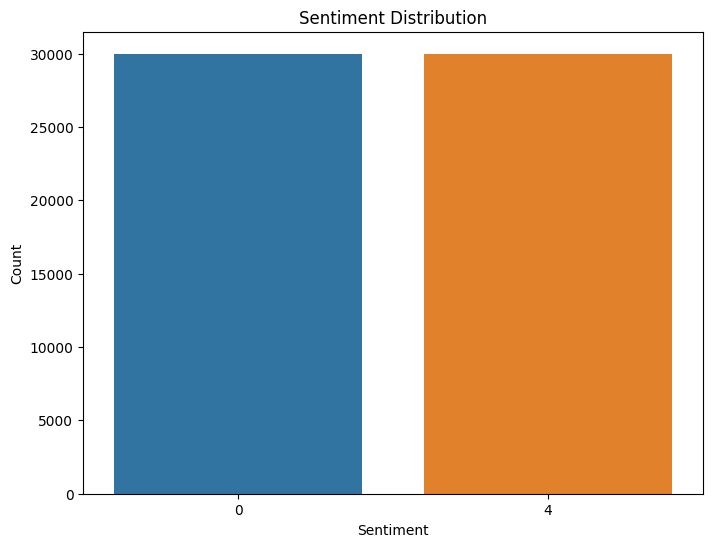

In [45]:
# Bar plot of sentiment distribution
sentiment_counts = data['Sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

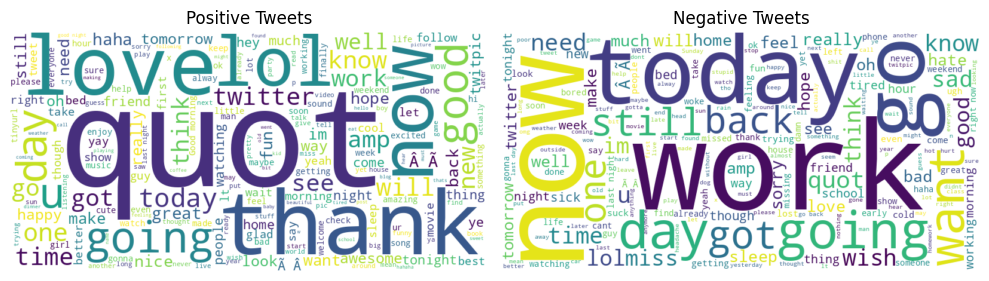

In [48]:
positive_tweets = data[data['Sentiment'] == 1]['Tweet']
negative_tweets = data[data['Sentiment'] == 0]['Tweet']

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_tweets))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Tweets')
plt.axis('off')

plt.tight_layout()
plt.show()

# **Feature Extraction Using BoW & TF-IDF**

In [9]:
X = data['ProcessedText']
y = data['Sentiment']

In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Bag-of-Words vectorization
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# **Training Models**

In [8]:
def train_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = [accuracy_score(y_test, y_pred),
              precision_score(y_test, y_pred, average='weighted'),
              recall_score(y_test, y_pred, average='weighted'),
              f1_score(y_test, y_pred, average='weighted')]
    return model, y_pred, scores

In [12]:
# Train and evaluate models
models = {
    'Decision Tree (BoW)': DecisionTreeClassifier(),
    'Decision Tree (TF-IDF)': DecisionTreeClassifier(),
    'XGBoost (BoW)': XGBClassifier(),
    'XGBoost (TF-IDF)': XGBClassifier(),
    'Naive Bayes (BoW)': MultinomialNB(),
    'Naive Bayes (TF-IDF)': MultinomialNB(),
    'Logistic Regression (BoW)': LogisticRegression(max_iter=60000),
    'Logistic Regression (TF-IDF)': LogisticRegression(max_iter=60000),
    'Random Forest (BoW)': RandomForestClassifier(),
    'Random Forest (TF-IDF)': RandomForestClassifier(),
    'SVC (BoW)': SVC(),
    'SVC (TF-IDF)': SVC(),
    'KNN (BoW)': KNeighborsClassifier(),
    'KNN (TF-IDF)': KNeighborsClassifier()
}

In [13]:
trained_models = {}
model_scores = []

In [14]:
for model_name, model in models.items():
    if 'BoW' in model_name:
        trained_model, y_pred, scores = train_model(model, X_train_bow, y_train, X_test_bow)
    elif 'TF-IDF' in model_name:
        trained_model, y_pred, scores = train_model(model, X_train_tfidf, y_train, X_test_tfidf)

    trained_models[model_name] = trained_model
    model_scores.append([model_name] + scores)

In [21]:
# Create a table to display the scores
table = [["Model", "Accuracy", "Precision", "Recall", "F1 Score"]] + model_scores
print(tabulate(table, headers="firstrow"))

Model                           Accuracy    Precision    Recall    F1 Score
----------------------------  ----------  -----------  --------  ----------
Decision Tree (BoW)             0.687917     0.689407  0.687917    0.687635
Decision Tree (TF-IDF)          0.683833     0.684565  0.683833    0.683748
XGBoost (BoW)                   0.734083     0.738795  0.734083    0.732296
XGBoost (TF-IDF)                0.736917     0.741027  0.736917    0.735361
Naive Bayes (BoW)               0.745        0.748421  0.745       0.74444
Naive Bayes (TF-IDF)            0.740667     0.74592   0.740667    0.73969
Logistic Regression (BoW)       0.756        0.755988  0.756       0.755977
Logistic Regression (TF-IDF)    0.76125      0.76126   0.76125     0.761205
Random Forest (BoW)             0.73775      0.739306  0.73775     0.737547
Random Forest (TF-IDF)          0.744        0.744619  0.744       0.743965
SVC (BoW)                       0.759583     0.760548  0.759583    0.759179
SVC (TF-IDF)  

# **Saving trained models and their scores in pickle files**

In [15]:
# Save the trained models
for model_name, model in trained_models.items():
    filename = model_name + '.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

In [22]:
# Save the scores to a CSV file
scores_df = pd.DataFrame(model_scores, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
scores_df.to_csv("model_scores.csv", index=False)

In [25]:
# Load the model scores from the CSV file
scores_df = pd.read_csv("model_scores.csv")

In [26]:
# Extract the model and vectorizer names from the 'Model' column
scores_df['Vectorizer'] = scores_df['Model'].apply(lambda x: 'BoW' if 'BoW' in x else 'TF-IDF')

In [39]:
# Find the best-performing model
best_model_row = scores_df.loc[scores_df['F1 Score'].idxmax()]
best_model_name = f"{best_model_row['Model']})"
best_model_filename = f"{best_model_row['Model']}.pickle"

In [40]:
best_model_name

'SVC (TF-IDF))'

In [35]:
# Load the best model from the pickle file
with open(best_model_filename, 'rb') as f:
    best_model = pickle.load(f)

# **Predicting Sentiment of Sentence**

In [36]:
# Function to predict sentiment of a sentence using the best model
def predict_sentiment(sentence):
    preprocessed_sentence = preprocess_tweet(sentence)
    if 'BoW' in best_model_name:
        sentence_vectorized = bow_vectorizer.transform([preprocessed_sentence])
    elif 'TF-IDF' in best_model_name:
        sentence_vectorized = tfidf_vectorizer.transform([preprocessed_sentence])
    sentiment = best_model.predict(sentence_vectorized)[0]
    return sentiment

In [37]:
# Example usage of the predict_sentiment function
user_input = input("Enter a sentence: ")
predicted_sentiment = predict_sentiment(user_input)
print("Predicted sentiment:")
# Print the predicted sentiment
if predicted_sentiment == 0:
    print("Negative")
else:
    print("Positive")

Enter a sentence: I am bad
Predicted sentiment:
Negative


# **Predicting Sentiment of Test.CSV file**

In [49]:
# Load the trained SVC model and TF-IDF vectorizer from the pickle files
with open("SVC (TF-IDF).pickle", 'rb') as f:
    svc_model = pickle.load(f)

In [50]:
# Load the test.csv file
test_data = pd.read_csv("test.csv")

# Preprocess the tweets in the test data using the TF-IDF vectorizer
test_tweets = tfidf_vectorizer.transform(test_data["Tweet"])

In [51]:
# Predict the sentiment using the SVC model
sentiments = svc_model.predict(test_tweets)

In [52]:
# Add the sentiment column to the test data
test_data["Sentiment"] = sentiments

In [54]:
# Display the updated test data
print(test_data)

        ID                                              Tweet  Sentiment
0        4  Reading my kindle2...  Love it... Lee childs i...          1
1        5  Ok, first assesment of the #kindle2 ...it fuck...          1
2        6  @kenburbary You'll love your Kindle2. I've had...          1
3        7  @mikefish  Fair enough. But i have the Kindle2...          0
4        8  @richardebaker no. it is too big. I'm quite ha...          1
..     ...                                                ...        ...
492  14072  Ask Programming: LaTeX or InDesign?: submitted...          1
493  14073  On that note, I hate Word. I hate Pages. I hat...          0
494  14074  Ahhh... back in a *real* text editing environm...          1
495  14075  Trouble in Iran, I see. Hmm. Iran. Iran so far...          0
496  14076  Reading the tweets coming out of Iran... The w...          0

[497 rows x 3 columns]
